# TrainFinalModel
Important: Use Python 3.8, not 3.10! Prophet is not compatible with 3.8 :(

In [1]:
import math
from datetime import datetime
from datetime import timedelta
import pandas as pd
from pathlib import Path
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.utilities import regressor_coefficients
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from matplotlib import pyplot as plt
from prophet.serialize import model_to_json, model_from_json
import math

/Users/simon/Documents/projects/energyconsumption-zurich-model/env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
# https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Switzerland
COVID_START = datetime(2020, 3, 1).date()
# https://www.admin.ch/gov/en/start/documentation/media-releases.msg-id-84127.html
# date taken as the second easing of restrictions during 2021
COVID_END = datetime(2021, 6, 1).date()

MODEL_PATH = Path("../data/model/")
TRAIN_DATA_PATH = Path('../data/consumption/final_train.parquet')
DATA_PATH_2022 = Path('../data/consumption/2022.parquet')

MODEL_NAME = "totalconsumption_rolling7day.json"
CONSUMPTION_EXPR = "NE5Consumption + NE7Consumption" # i.e. "NE5Consumption + NE7Consumption", "NE5Consumption", "NE7Consumption"
ROLLING_WINDOW = 7
CONFIDENCE_INTERVAL = 0.95
USE_WEEK_SEASONALITY = False
USE_HOLIDAYS = False

In [7]:
"""
    return (spark.read.format("parquet").load(path)
                                      .withColumn("y", f.expr(CONSUMPTION_EXPR))
                                      .withColumn("CosYearTemp", f.expr("Temperature * cos(dayofyear(Date) * 2 * pi() / 365)"))
                                      .withColumn("SinYearTemp", f.expr("Temperature * sin(dayofyear(Date) * 2 * pi() / 365)"))
                                      .selectExpr("Date as ds", "y", "CosYearTemp", "SinYearTemp")
                                      .orderBy("ds")
         ).toPandas().rolling(ROLLING_WINDOW, on="ds").mean().dropna()[:-ROLLING_WINDOW]
"""

train = pd.read_parquet(TRAIN_DATA_PATH, engine='pyarrow')
train['Date'] = pd.to_datetime(train['Date'])
train['y'] = train['NE5Consumption'] + train['NE7Consumption']
train['CosYearTemp'] = train.apply(lambda row: row['Temperature'] * math.cos(row['Date'].dayofyear * 2 * math.pi / 365), axis=1)
train['SinYearTemp'] = train.apply(lambda row: row['Temperature'] * math.sin(row['Date'].dayofyear * 2 * math.pi / 365), axis=1)
train.rename(columns={'Date': 'ds'}, inplace=True)
train = train.sort_values('ds')
train = train.rolling(window=ROLLING_WINDOW, on='ds').mean().dropna()[:-ROLLING_WINDOW]

In [4]:
# add covid as a one-off holiday
covid = pd.DataFrame([
    {'holiday': 'covid', 'ds': COVID_START, 'lower_window': 0, 'ds_upper': COVID_END}
])

covid['upper_window'] = (covid['ds_upper'] - covid['ds']).dt.days

In [23]:
m = Prophet(
    holidays = covid, 
    weekly_seasonality = USE_WEEK_SEASONALITY,
    changepoint_prior_scale = 0.005,
    changepoint_range=1,
    interval_width=CONFIDENCE_INTERVAL,
    uncertainty_samples = 10000
)

if USE_HOLIDAYS:
    m.add_country_holidays(country_name='CH')
  
m.add_regressor("CosYearTemp", prior_scale = 0.05, standardize = True, mode = "additive")
m.add_regressor("SinYearTemp", prior_scale = 0.05, standardize = True, mode = "additive")

m.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/simon/Documents/projects/energyconsumption-zurich-model/env/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/simon/Documents/projects/energyconsumption-zurich-model/env/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.7341
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         15270    0.00657831       7965.41           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       15330.5   0.000112701       763.492      0.5663      0.5663      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       15348.3    0.00688731       4987.96           1           1      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       15353.5   0.000529925        545.48      0.9925      0.9925      467   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       15354.1   4.35282e-06       648.839      0.4233      0.4233      598   
    Iter      log prob        ||dx||      ||grad||       alpha  

In [24]:
forecastTrain = m.predict(train)

/Users/simon/Documents/projects/energyconsumption-zurich-model/env/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/simon/Documents/projects/energyconsumption-zurich-model/env/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/simon/Documents/projects/energyconsumption-zurich-model/env/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/simon/Documents/projects/energyconsumption-zurich-model/env/lib/python3.8/site-packages/prophet/for

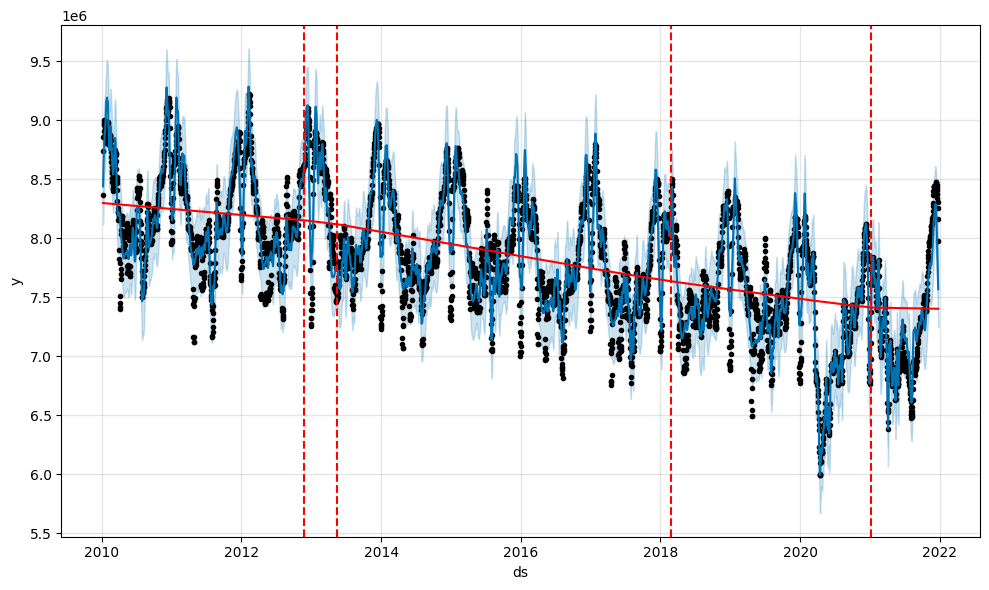

In [25]:
fig = m.plot(forecastTrain)
a = add_changepoints_to_plot(fig.gca(), m, forecastTrain)

In [26]:
mse = mean_squared_error(train["y"].to_numpy(), forecastTrain["yhat"].to_numpy())
mse

27298644527.564865

In [27]:
rmse = math.sqrt(mse)
rmse

165223.01452147902

In [28]:
mean_absolute_percentage_error(train["y"].to_numpy(), forecastTrain["yhat"].to_numpy())

0.015007961841507045

In [29]:
regressor_coefficients(m)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,CosYearTemp,additive,-4.510686,-46687.244909,-46687.244909,-46687.244909
1,SinYearTemp,additive,-1.329717,-20799.399467,-20799.399467,-20799.399467


In [30]:
plotData = pd.DataFrame(
  {
    "Actual": train["y"].array,
    "PredictedMean": forecastTrain["yhat"].array,
    "PredictedHigh": forecastTrain["yhat_upper"].array,
    "PredictedLow": forecastTrain["yhat_lower"].array
  },
  index=train["ds"]
)

plotData.index = pd.to_datetime(plotData.index)
plotData = plotData.sort_index()

In [31]:
def plot(data):
  fig, ax = plt.subplots()
  fig.set_size_inches(12, 8)
  fig.patch.set_facecolor('white')
  ax.plot(data.index, data["Actual"])
  ax.fill_between(data.index, data["PredictedHigh"], data["PredictedLow"], color='orange', alpha=.2)

In [32]:
plotData.head()

,Actual,PredictedMean,PredictedHigh,PredictedLow
ds,,,,
2010-01-07,8.363917e+06,8.438841e+06,8.759927e+06,8.115343e+06
2010-01-08,8.734822e+06,8.519322e+06,8.840984e+06,8.200525e+06
2010-01-09,8.860400e+06,8.589899e+06,8.913191e+06,8.265598e+06
2010-01-10,8.908780e+06,8.645982e+06,8.976827e+06,8.317910e+06
2010-01-11,8.955284e+06,8.692545e+06,9.013614e+06,8.377745e+06


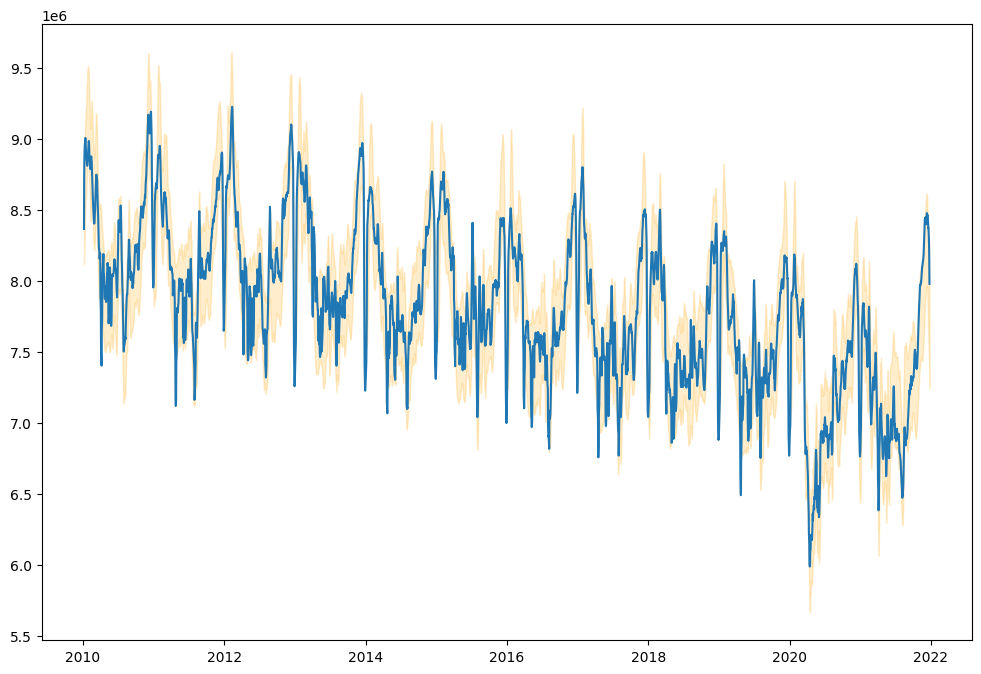

In [33]:
plot(plotData)

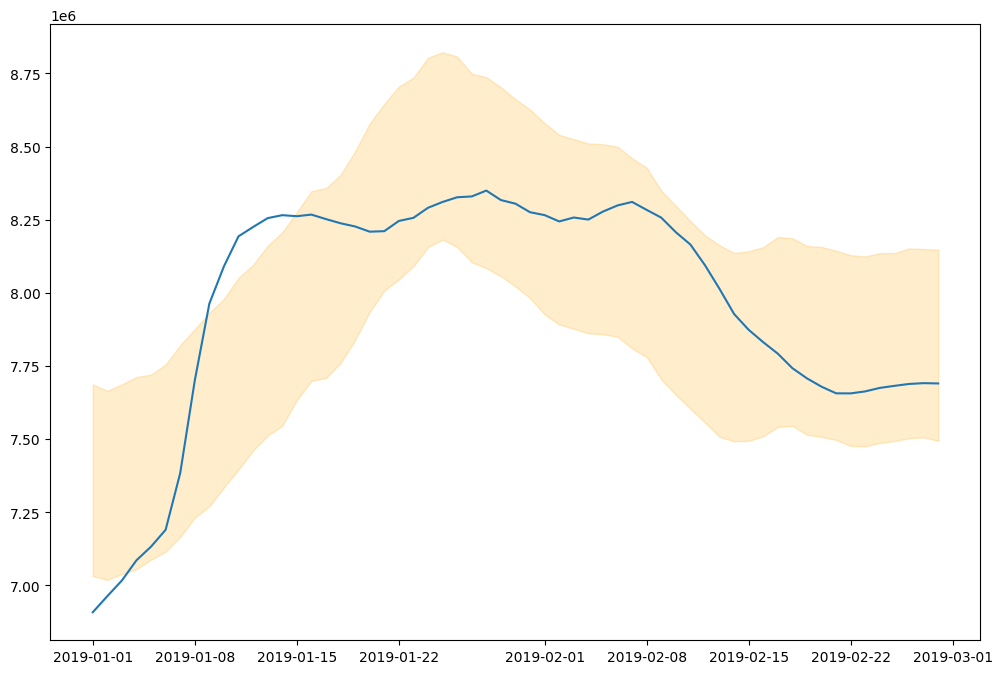

In [34]:
plot(plotData[(plotData.index >= datetime(2019, 1, 1)) & (plotData.index < datetime(2019, 3, 1))])

In [35]:
with open(MODEL_PATH / MODEL_NAME, 'w') as fout:
    fout.write(model_to_json(m))

/Users/simon/Documents/projects/energyconsumption-zurich-model/env/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/simon/Documents/projects/energyconsumption-zurich-model/env/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


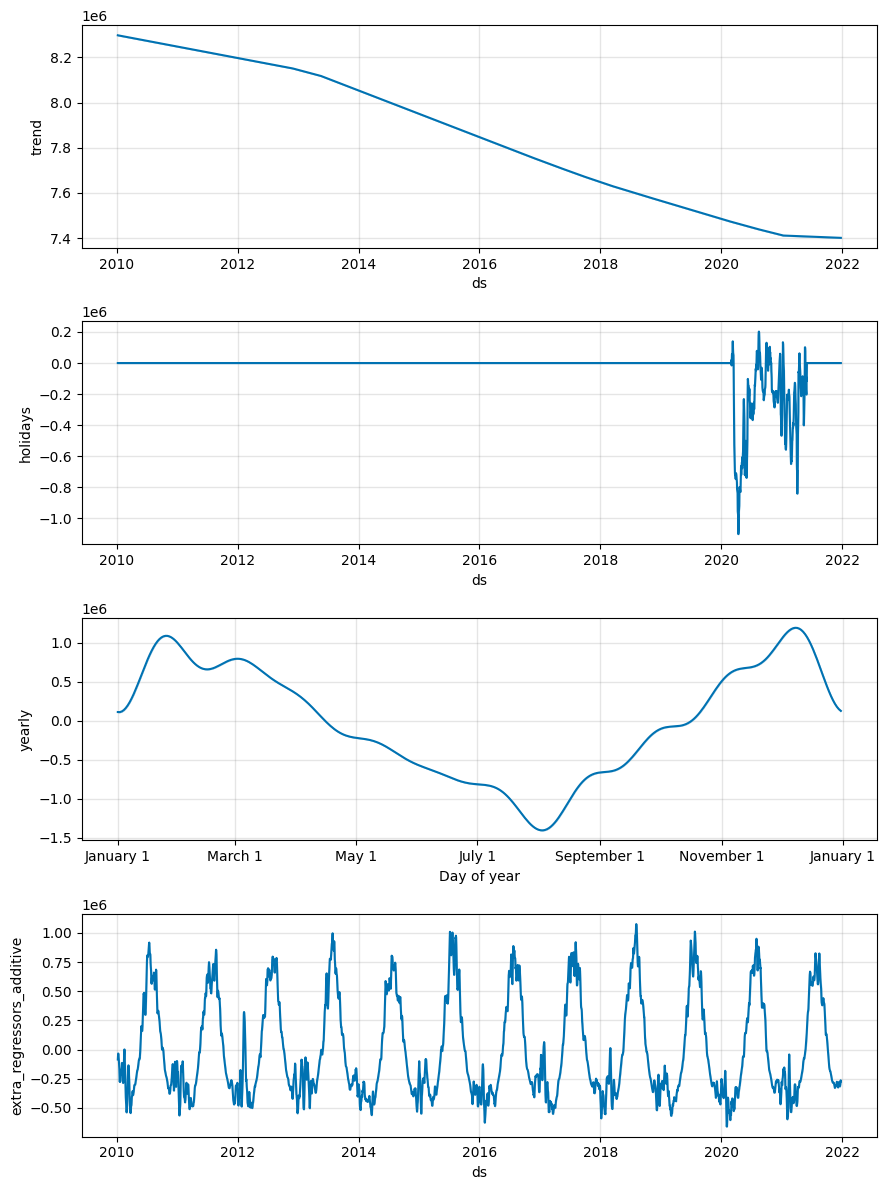

In [36]:
fig = m.plot_components(forecastTrain)

## 2022 test

In [37]:
df_2022 = pd.read_parquet(DATA_PATH_2022, engine='pyarrow')
df_2022['Date'] = pd.to_datetime(df_2022['Date'])
df_2022['y'] = df_2022['NE5Consumption'] + df_2022['NE7Consumption']

df_2022['CosYearTemp'] = df_2022.apply(lambda row: row['Temperature'] * math.cos(row['Date'].dayofyear * 2 * math.pi / 365), axis=1)
df_2022['SinYearTemp'] = df_2022.apply(lambda row: row['Temperature'] * math.sin(row['Date'].dayofyear * 2 * math.pi / 365), axis=1)

df_2022.rename(columns={'Date': 'ds'}, inplace=True)
df_2022 = df_2022.sort_values('ds')

df_2022 = df_2022.rolling(ROLLING_WINDOW, on='ds').mean().dropna()

forecastTrain = m.predict(df_2022)

/Users/simon/Documents/projects/energyconsumption-zurich-model/env/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/simon/Documents/projects/energyconsumption-zurich-model/env/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/simon/Documents/projects/energyconsumption-zurich-model/env/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/simon/Documents/projects/energyconsumption-zurich-model/env/lib/python3.8/site-packages/prophet/for

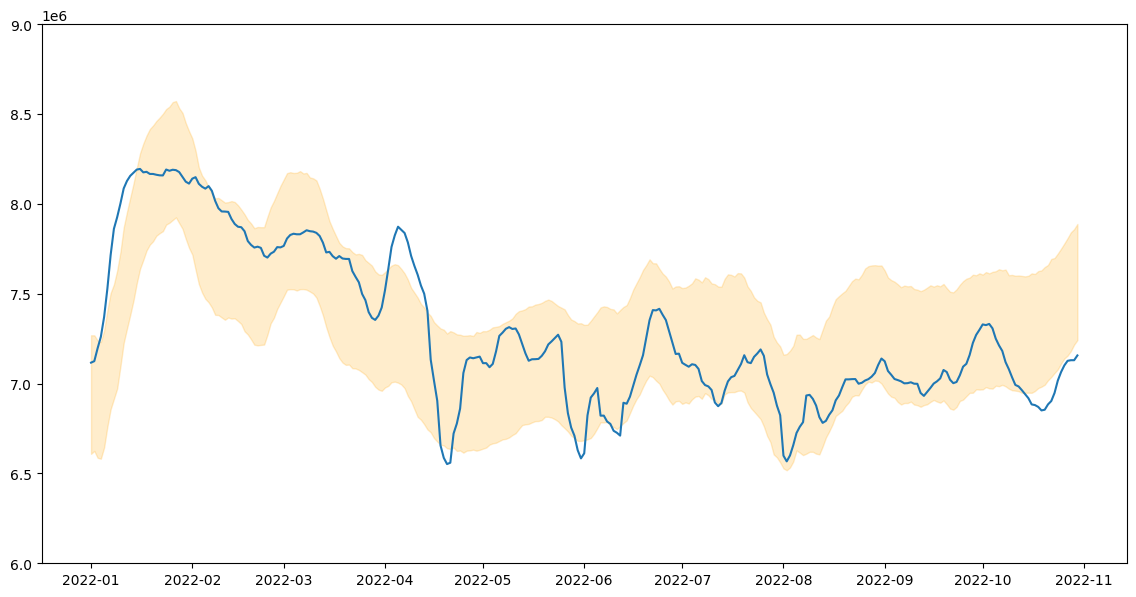

In [38]:
def plot(data):
    fig, ax = plt.subplots()
    fig.set_size_inches(14, 7)
    fig.patch.set_facecolor('white')
    ax.plot(data.index, data["Actual"])
    ax.fill_between(data.index, data["PredictedHigh"], data["PredictedLow"], color='orange', alpha=.2)
    ax.set_ylim(6e+06, 9e+06)

plotData = pd.DataFrame(
  {
    "Actual": df_2022["y"].array,
    "PredictedMean": forecastTrain["yhat"].array,
    "PredictedHigh": forecastTrain["yhat_upper"].array,
    "PredictedLow": forecastTrain["yhat_lower"].array
  },
  index=df_2022["ds"]
)

plotData.index = pd.to_datetime(plotData.index)
plotData = plotData.sort_index()

plot(plotData)

In [39]:
#plotData = plotData.div(1000000).round(2)
plotData

,Actual,PredictedMean,PredictedHigh,PredictedLow
ds,,,,
2022-01-01,7.116659e+06,6.941962e+06,7.269013e+06,6.608997e+06
2022-01-02,7.125017e+06,6.946519e+06,7.268743e+06,6.625435e+06
2022-01-03,7.195796e+06,6.918091e+06,7.240155e+06,6.587209e+06
2022-01-04,7.260156e+06,6.904356e+06,7.230825e+06,6.581929e+06
2022-01-05,7.370544e+06,6.970649e+06,7.294616e+06,6.644442e+06
...,...,...,...,...
2022-10-26,7.101381e+06,7.456513e+06,7.779844e+06,7.139588e+06
2022-10-27,7.126852e+06,7.482943e+06,7.809912e+06,7.155897e+06
2022-10-28,7.130265e+06,7.509719e+06,7.842031e+06,7.181175e+06


In [ ]:
plotData.iloc[18:30]

In [ ]:
train

,ds,CosYearTemp,NE5Consumption,NE7Consumption,SinYearTemp,Temperature,y
6,2010-01-07,-3.159030,2.254180e+06,6.109737e+06,-0.263060,-3.170238,8.363917e+06
7,2010-01-08,-3.853628,2.367458e+06,6.367364e+06,-0.312660,-3.867857,8.734822e+06
8,2010-01-09,-4.192654,2.399527e+06,6.460874e+06,-0.400371,-4.214286,8.860400e+06
9,2010-01-10,-4.124035,2.408979e+06,6.499801e+06,-0.473630,-4.154167,8.908780e+06
10,2010-01-11,-3.781718,2.428411e+06,6.526873e+06,-0.525976,-3.820833,8.955284e+06
...,...,...,...,...,...,...,...
4371,2021-12-20,1.553156,2.637110e+06,5.705483e+06,-0.396950,1.603571,8.342593e+06
4372,2021-12-21,1.309127,2.627246e+06,5.676196e+06,-0.334187,1.351190,8.303442e+06
4373,2021-12-22,0.818497,2.621093e+06,5.633777e+06,-0.227651,0.848214,8.254870e+06
4374,2021-12-23,0.626437,2.600227e+06,5.564452e+06,-0.154947,0.645238,8.164679e+06
